In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from HydroWeno.Advector import Advector, advection_flux
from HydroWeno.Simulation import Grid
from HydroWeno.Weno import reconstruct_weno_nm_z, reconstruct_weno_z
from tqdm.notebook import tqdm

In [2]:
NumGhost = 3
NumCells = 100
GriMax = NumCells + 2 * NumGhost
GriStart = 0.0
GriEnd = 1.0

interfaces = np.linspace(0, 1, NumCells+1)
grid = Grid(interfaces, 4)
data = np.zeros((2, grid.griMax))
data[0, :] = 1.0
data[1, :] = 0.0
data[1, 30:40] = 1.0

def reflecting_bc(position='Lower'):
    if position == 'Lower':
        def reflecting_lower(grid, V):
            for i in range(grid.numGhost):
                k0 = 2 * grid.numGhost - 1

                V[:, i] = V[:, k0-i]
        return reflecting_lower
    elif position == 'Upper':
        def reflecting_upper(grid, V):
            for i in range(grid.numGhost):
                k0 = 2 * grid.numGhost - 1
                k1 = grid.griEnd - grid.numGhost

                V[:, k1+k0-i] = V[:, k1+i]
        return reflecting_upper
    
    raise ValueError('Unknown position argument %s. Expected: "Lower"|"Upper"' % position)
    
lower_bc = reflecting_bc('Lower')
upper_bc = reflecting_bc('Upper')

def bcs(grid, V):
    lower_bc(grid, V)
    upper_bc(grid, V)
    

In [ ]:
ad = Advector(grid, data, bcs, reconstruct_weno_nm_z)

In [ ]:
for i in range(100):
    newData = ad.step(0.001)

In [ ]:
dt = 0.8 * np.min(grid.dx / 1.0)
dt

In [ ]:
plt.figure()
plt.plot(grid.cc[grid.griBeg:grid.griEnd], data[0, grid.griBeg:grid.griEnd])
plt.plot(grid.cc[grid.griBeg:grid.griEnd], data[1, grid.griBeg:grid.griEnd])
plt.plot(grid.cc[grid.griBeg:grid.griEnd], ad.data[1, grid.griBeg:grid.griEnd])
# plt.plot(grid.cc[grid.griBeg:grid.griEnd], ad.data[0, grid.griBeg:grid.griEnd])

In [ ]:
ad.data

In [ ]:
plt.figure()
plt.plot(advection_flux(reconstruct_weno_nm_z(data, grid.dx)).T)

In [ ]:
advection_flux(reconstruct_weno_nm_z(data, grid.dx)).T

In [ ]:
ad.data

In [3]:
from ReadAtmost import read_atmost

In [4]:
atmost = read_atmost()
atmost.to_SI()

In [5]:
atmost.vz1

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.82061369e-05,  8.92257134e-06, ...,
        -8.04352292e-06, -2.78246919e-05,  0.00000000e+00],
       [ 0.00000000e+00,  4.27828599e-05,  2.09654109e-05, ...,
        -1.87824248e-05, -6.52495912e-05,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  1.81003670e+02,  3.61880526e+02, ...,
        -6.92319681e-03,  5.35991717e-04,  0.00000000e+00],
       [ 0.00000000e+00,  1.81611087e+02,  3.63092597e+02, ...,
        -7.40826622e-03,  3.04333578e-04,  0.00000000e+00],
       [ 0.00000000e+00,  1.81836101e+02,  3.63541589e+02, ...,
        -7.59057593e-03,  2.15070551e-04,  0.00000000e+00]])

In [6]:
startingZs = np.copy(atmost.z1[-1][::-1])
NumInterfaces = 2001
startingZsInterp = np.interp(np.linspace(0, 1, NumInterfaces), np.linspace(0, 1, startingZs.shape[0]), startingZs)
zInterfaces = startingZsInterp
zcc = 0.5 * (zInterfaces[1:] + zInterfaces[:-1])

<IPython.core.display.Javascript object>


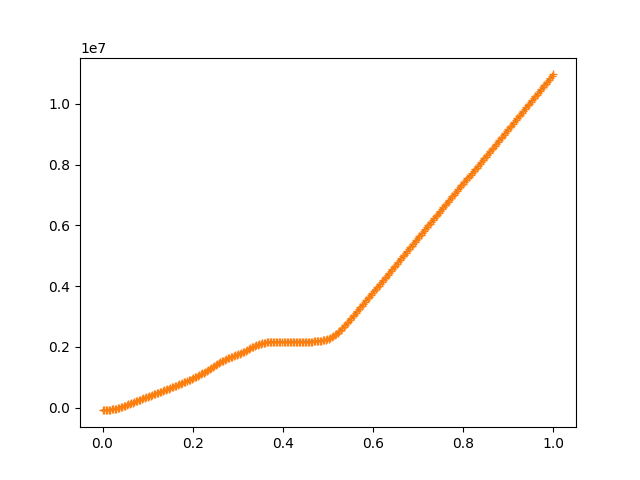

In [7]:
plt.figure()
plt.plot(np.linspace(0, 1, NumInterfaces), startingZsInterp)
plt.plot(np.linspace(0, 1, startingZs.shape[0]), startingZs, '+')

In [9]:
def velrho(idx):
    vel = np.interp(zcc, atmost.z1[idx, ::-1], atmost.vz1[idx, ::-1])
    rho = np.interp(zcc, atmost.z1[idx, ::-1], atmost.d1[idx, ::-1])
    
    return np.stack((vel, rho))

In [10]:
idx = 1000
vr = velrho(idx)

<IPython.core.display.Javascript object>


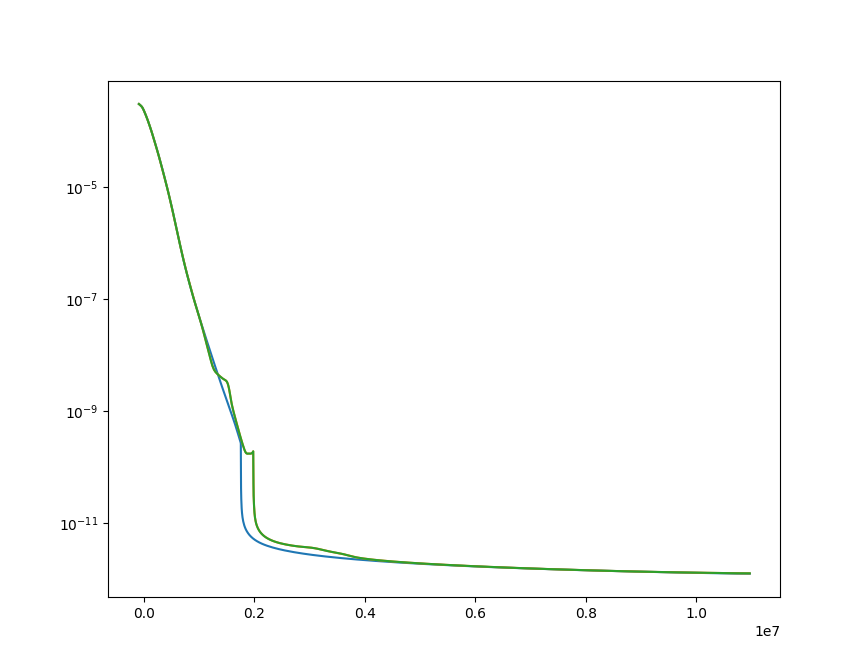

In [11]:
plt.figure()
plt.semilogy(atmost.z1[0], atmost.d1[0])
plt.semilogy(zcc, vr[1])
plt.semilogy(atmost.z1[idx], atmost.d1[idx])

In [12]:
np.diff(atmost.z1[idx, ::-1]).min()

232.3798810315784

In [13]:
grid = Grid(zInterfaces, 4)
ad = Advector(grid, velrho(0), bcs, reconstruct_weno_z)
idx = 0

In [42]:
def cfl(data):
    vel = np.abs(data[0])
    dt = 0.8 * np.min(grid.dx / vel)
    return dt

class MsLightweaverAdvector:
    def __init__(self, grid, atmost, idx=0):
        self.grid = grid
        self.atmost = atmost
        self.idx = idx
        startData = np.stack((self.vel(idx), self.rho(idx)))
        self.ad = Advector(grid, startData, bcs, reconstruct_weno_nm_z)
                             
    def rho(self, idx):
        rho = np.interp(grid.cc, self.atmost.z1[idx, ::-1], self.atmost.d1[idx, ::-1]) * 1e7
        return rho
    
    def vel(self, idx):
        vel = np.interp(grid.cc, self.atmost.z1[idx, ::-1], self.atmost.vz1[idx, ::-1])
        return vel
    
    def step(self):
        self.ad.data[0, :] = self.vel(self.idx)
        dtRadyn = self.atmost.dt[self.idx+1]
        dtMax = cfl(self.ad.data)
        if dtRadyn > dtMax:
            subTime = 0.0
            for i in range(500):
                alpha = subTime / dtRadyn
                self.ad.data[0, :] = (1.0 - alpha) * self.vel(self.idx) + alpha * self.vel(self.idx)
                dtMax = cfl(self.ad.data)
                dt = dtMax
                if subTime + dt > dtRadyn:
                    dt = dtRadyn - subTime
                self.ad.step(dt)
                subTime += dt
                if subTime >= dtRadyn:
                    break
            else:
                raise Exception('Convergence')
        else:
            self.ad.step(dtRadyn)
        self.idx += 1

In [43]:
ms = MsLightweaverAdvector(grid, atmost, idx=0)

In [44]:
for i in tqdm(range(atmost.time.shape[0]-1)):
    ms.step()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
%prun ms.step()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


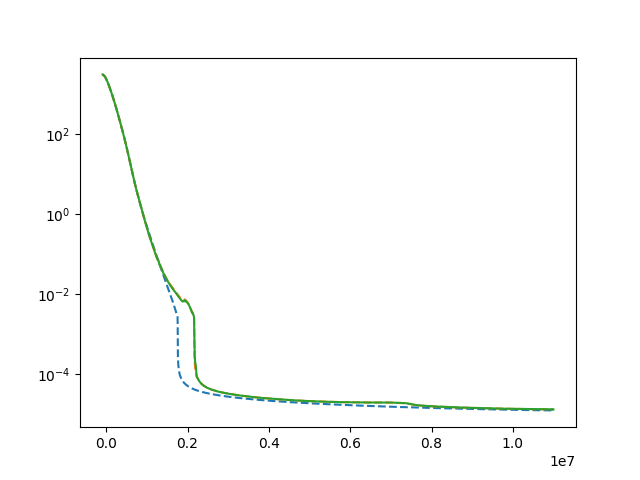

In [45]:
plt.figure()
plt.semilogy(ms.grid.cc, ms.rho(0), '--')
plt.semilogy(ms.grid.cc, ms.rho(1792), '--')
plt.semilogy(ms.grid.cc, ms.ad.data[1])

In [ ]:
atmost.time[100]

In [ ]:
ms.ad.data[0]

In [ ]:
ms.vel(ms.idx)